In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def loadData(outputFile,inputFile):
    taxiData=pd.read_csv(inputFile)
    taxiData['TIMESTAMP'] = taxiData['TIMESTAMP'].astype('int')
    taxiData['TIMESTAMP']=taxiData['TIMESTAMP'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    taxiData['TIMESTAMP'] = pd.to_datetime(taxiData['TIMESTAMP'])
    taxiData['TIMESTAMP']=taxiData['TIMESTAMP'].dt.round('60min')
    taxiData['DATE']=pd.to_datetime(taxiData['TIMESTAMP']).dt.date
    timeData=taxiData.groupby(['TIMESTAMP']).size().to_frame(name='TAXI_COUNT').reset_index()
    OUTPUT=timeData.iloc[:-1,:]
    OUTPUT.to_csv(outputFile)

In [3]:
loadData('outTest.csv','train.csv')

In [4]:
def processData(outFile):
    loadData = pd.read_csv(outFile, header=0, index_col=0, parse_dates=True, squeeze=True)
    loadData['TAXI_COUNT'] = loadData['TAXI_COUNT'].values
    loadData['TAXI_COUNT'] = loadData['TAXI_COUNT'].astype('float32')
    loadData = loadData.iloc[: , 1:]
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_obj=scaler.fit(loadData)
    loadData = scaler.fit_transform(loadData)
    loadData=loadData.reshape(len(loadData),)
    return loadData,df_obj

In [5]:
df,df_obj=processData('outTest.csv')

In [6]:
def dataPreparation(taxiData,seqLen,numOfEntry):
    feature = []
    label = []
    for i in range(numOfEntry):
        feature.append(taxiData[i:i+seqLen]) 
        label.append(taxiData[i+seqLen])
    feature = np.array(feature) 
    feature = np.expand_dims(feature, axis=2) 
    label = np.array(label) 
    label = np.expand_dims(label, axis=1)
    return feature,label

In [7]:
train_size  = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]
print(len(train), len(test))
seqLen = 30
numOfEntry = len(df) - seqLen 
outPutSeq= 30
feature_Train,label_Train=dataPreparation(train,seqLen,len(train)-seqLen)
feature_Test,label_Test=dataPreparation(test,seqLen,len(test)-seqLen)

7008 1752


In [8]:
feature_Test.shape

(1722, 30, 1)

In [9]:
#RNN 
learning_rate = 0.0001    
nepoch = 10              
T = 30                   # length of sequence
hidden_dim = 90         
output_dim = 1

In [10]:
# Need to check the what they are 
bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [11]:
# Random weights of the network
U = np.random.uniform(0, 1, (hidden_dim, T)) # input and hidden layers
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim)) # hidden and output layers
V = np.random.uniform(0, 1, (output_dim, hidden_dim)) #  in the RNN layer (hidden layer)

In [12]:
def sigmoid(x):
    #return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    #return np.maximum(0,x)
    return 1 / (1 + np.exp(-x))

In [ ]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(label_Train.shape[0]):
        x, y = feature_Train[i], label_Train[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # (100,1) here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # (50,1) we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)      # (100,1) multiplication matrix for input * weight of input to hidden
            mulw = np.dot(W, prev_s)         # (100, 1) multiplication matrix for previous * weight of hidden to out
            add = mulw + mulu   #(100,1)
            s = sigmoid(add)    # (100,1) activation of the output layers 
            mulv = np.dot(V, s) # (1,1) finale value 
            prev_s = s # storing the value of current value for next run 

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    # check loss on val
    val_loss = 0.0
    for i in range(label_Test.shape[0]):
        x, y = feature_Test[i], label_Test[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    # train model
    for i in range(label_Train.shape[0]):
        x, y = feature_Train[i], label_Train[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
        # derivative of pred
        dmulv = (mulv - y)
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i

            dV += dV_t
            dU += dU_t
            dW += dW_t
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[5924937.30131596]] , Val Loss:  [[1460003.9540552]]
Epoch:  2 , Loss:  [[116.35462574]] , Val Loss:  [[34.75915866]]


In [14]:
preds = []
for i in range(label_Train.shape[0]):
    x, y = feature_Train[i], label_Train[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

Train Score: 1239.02 RMSE


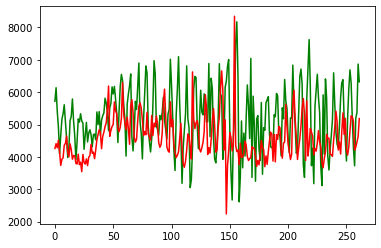

In [15]:
preds = df_obj.inverse_transform(preds[:, 0])
label_Train = df_obj.inverse_transform(label_Train)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(preds[:,0], label_Train[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
plt.plot(preds[:, 0], 'g')
plt.plot(label_Train[:, 0], 'r')
plt.show()

Test Score: 1332.30 RMSE


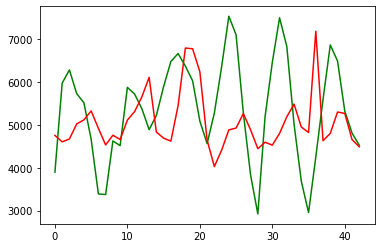

In [16]:
preds = []
for i in range(label_Test.shape[0]):
    x, y = feature_Test[i], label_Test[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

preds = df_obj.inverse_transform(preds[:, 0])
label_Test = df_obj.inverse_transform(label_Test)
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(preds[:,0], label_Test[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
plt.plot(preds[:, 0], 'g')
plt.plot(label_Test[:, 0], 'r')
plt.show()

In [82]:
preds

array([[ -543.99633752],
       [ 3029.82712769],
       [ -274.39363426],
       [ 2445.78069107],
       [  300.77441797],
       [ 2308.76730931],
       [ 1513.50431432],
       [ 1680.45414804],
       [ 2229.99658177],
       [ 1410.93645946],
       [  876.52453877],
       [ 2111.19435288],
       [-1592.00056062],
       [ 3136.80577282],
       [ -821.75478101],
       [ 2754.54914517],
       [ -159.03128993],
       [ 2570.40163972],
       [  372.61793644],
       [ 2171.73514845],
       [ 1416.80103181],
       [ 1295.46384887],
       [ 2229.20049952],
       [ 1428.78800869],
       [  714.71668682],
       [ 2152.17314266],
       [-1039.67554808],
       [ 3130.27058778],
       [ -638.08711486],
       [ 2850.95224606],
       [  -96.12941798],
       [ 2365.92587022],
       [  559.19715523],
       [ 2149.06838738],
       [ 1491.63941617],
       [ 1414.18391107],
       [ 2325.37308773],
       [ 1604.54394152],
       [  986.89531671],
       [ 2170.67837441],


array([[-2.06104556e-01],
       [ 5.26086282e-01],
       [-1.50869419e-01],
       [ 4.06429154e-01],
       [-3.30312598e-02],
       [ 3.78358394e-01],
       [ 2.15428052e-01],
       [ 2.49632075e-01],
       [ 3.62220158e-01],
       [ 1.94414355e-01],
       [ 8.49261511e-02],
       [ 3.37880427e-01],
       [-4.20815522e-01],
       [ 5.48003644e-01],
       [-2.63010609e-01],
       [ 4.69688416e-01],
       [-1.27234437e-01],
       [ 4.31961002e-01],
       [-1.83122435e-02],
       [ 3.50283786e-01],
       [ 1.95615865e-01],
       [ 1.70756782e-01],
       [ 3.62057060e-01],
       [ 1.98071710e-01],
       [ 5.17755975e-02],
       [ 3.46275999e-01],
       [-3.07657355e-01],
       [ 5.46664741e-01],
       [-2.25381503e-01],
       [ 4.89439102e-01],
       [-1.14347350e-01],
       [ 3.90068814e-01],
       [ 1.99133700e-02],
       [ 3.45639909e-01],
       [ 2.10948458e-01],
       [ 1.95079680e-01],
       [ 3.81760520e-01],
       [ 2.34079891e-01],
       [ 1.0